### カリキュラム - 【AIコース】教師なし学習　Feature Selection 3 wrapper method

In [1]:
import pandas as pd
df_wine = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data", header = None)
X = df_wine.iloc[:,1:].values
Y = df_wine.iloc[:,0].values
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 13)

In [2]:
# model building
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
# feature selection
# 特徴量一つだけ削除
from sklearn.feature_selection import RFE
rfe = RFE(estimator = lr, n_features_to_select = 12)
X_train_rfe = rfe.fit_transform(X_train, y_train)

In [3]:
# check the feature eliminated
import numpy as np
print(rfe.support_)
print(np.where(np.invert(rfe.support_)))

[ True  True  True  True False  True  True  True  True  True  True  True
  True]
(array([4]),)


In [4]:
# check performance
from sklearn.metrics import accuracy_score
lr.fit(X_train, y_train)
acc_train = accuracy_score(y_train, lr.predict(X_train))
acc = accuracy_score(y_test, lr.predict(X_test))

lr.fit(X_train_rfe, y_train)
X_test_rfe = X_test[:, rfe.support_]
acc_rfe_train = accuracy_score(y_train, lr.predict(X_train_rfe))
acc_rfe = accuracy_score(y_test, lr.predict(X_test_rfe))
print("all features | without 5th feature")
print("train: ", acc_train, "| ", acc_rfe_train)
print("test: ", acc, "| ", acc_rfe)

all features | without 5th feature
train:  0.967741935484 |  0.975806451613
test:  0.925925925926 |  0.925925925926


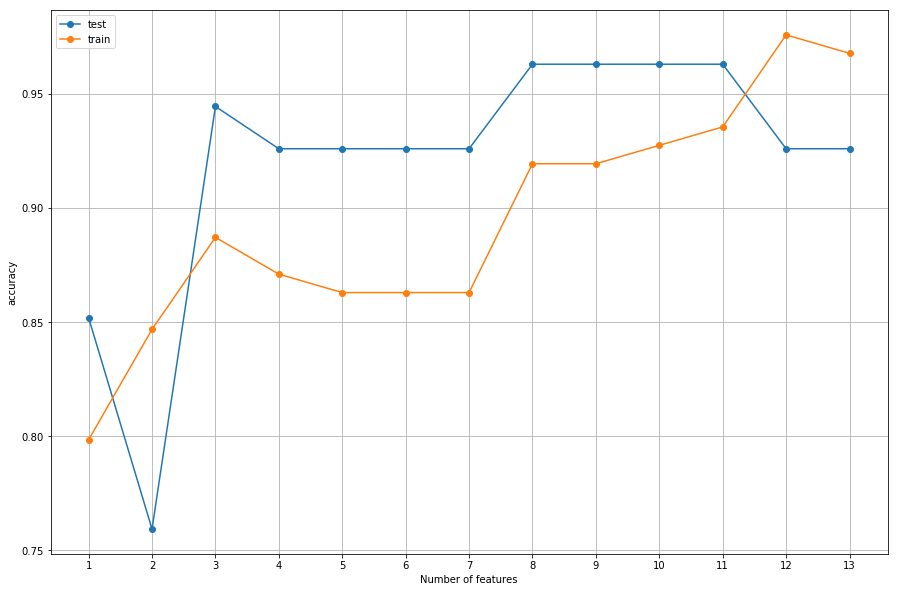

In [5]:
# 特徴量による精度の変化
acc_rfe_train = []
acc_rfe = []
n_features = []
for i in range(1, 13 + 1):
    rfe = RFE(lr, i)
    X_train_rfe = rfe.fit_transform(X_train, y_train)
    X_test_rfe = X_test[:, rfe.support_]
    lr.fit(X_train_rfe, y_train)
    acc_rfe_train.append(accuracy_score(y_train, lr.predict(X_train_rfe)))
    acc_rfe.append(accuracy_score(y_test, lr.predict(X_test_rfe)))
    n_features.append(X_train_rfe.shape[1])

import matplotlib.pyplot as plt
plt.figure(figsize = (15, 10))
plt.plot(n_features, acc_rfe, label = "test", marker = "o")
plt.plot(n_features, acc_rfe_train, label = "train", marker = "o")
plt.legend()
plt.grid()
plt.xticks(range(1, 13 + 1))
plt.ylabel("accuracy")
plt.xlabel("Number of features")
plt.show()

In [6]:
rfe = RFE(estimator = lr, n_features_to_select = 8)
X_train_rfe = rfe.fit_transform(X_train, y_train)
print(np.where(rfe.support_))
X_test_rfe = X_test[:, rfe.support_]
rfe.fit(X_train_rfe, y_train)
acc_rfe_train = accuracy_score(y_train, rfe.predict(X_train_rfe))
acc_rfe = accuracy_score(y_test, rfe.predict(X_test_rfe))
print("all 13 features | only 8 features")
print("train: ", acc_train, "| ", acc_rfe_train)
print("test: ", acc, "| ", acc_rfe)

(array([ 1,  2,  3,  5,  6,  9, 10, 11]),)
all 13 features | only 8 features
train:  0.967741935484 |  0.91935483871
test:  0.925925925926 |  0.962962962963


In [7]:
import itertools
# 並べる対象
s = range(13)
# 並べてリスト化
c = list(itertools.combinations(s, 12));
# 組み合わせの対象
print(len(c))

13


In [8]:
n = 0
for i in range(1, 14):
    n += len(list(itertools.combinations(s, i)));
print(n)

8191


In [56]:
# SBS
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from sklearn.base import clone
from itertools import combinations
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class SBS():
    def __init__(self, estimator, k_features, scoring = accuracy_score, test_size = 0.25, random_state = 1):
        self.scoring = scoring
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state
    
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = self.test_size, random_state = self.random_state)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]
        
        while dim > self.k_features:
            scores = []
            subsets = []
            for p in combinations(self.indices_, r = dim - 1):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        
        return self
    
    def transform(self, X):
        return X[:, self.indices_]
    
    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.estimator.fit(X_train[:, indices], y_train)
        y_pred = self.estimator.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [57]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/'
                      'ml/machine-learning-databases/wine/wine.data', header = None)
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

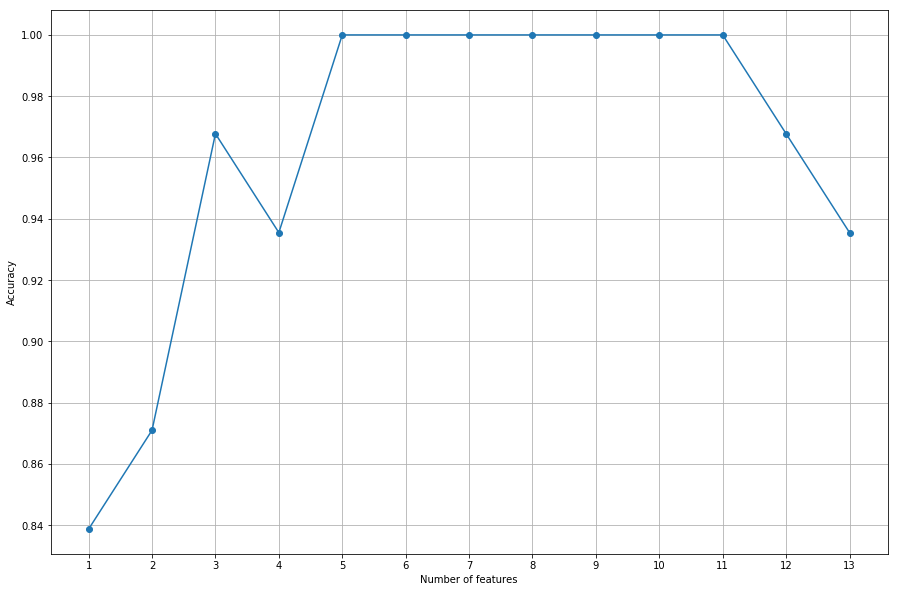

Selected top 5 features:
 Int64Index([1, 2, 4, 11, 13], dtype='int64')

Performance using all features:

Training accuracy:  0.983870967742

Performance using the top 5 features:

Training accuracy:  0.959677419355
Test accuracy: 0.962962962963


In [60]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

knn = KNeighborsClassifier(n_neighbors = 2)
sbs = SBS(knn, k_features = 1)
sbs.fit(X_train_std, y_train)

k_feat = [len(k) for k in sbs.subsets_]

plt.figure(figsize = (15, 10))
plt.plot(k_feat, sbs.scores_, marker = "o")
plt.ylabel("Accuracy")
plt.xlabel("Number of features")
plt.xticks(range(1, 13 + 1))
plt.grid()
plt.show()

k5 = list(sbs.subsets_[8])
print("Selected top 5 features:\n", df_wine.columns[1:][k5])

knn.fit(X_train_std, y_train)
print("\nPerformance using all features:\n")
print("Training accuracy: ", knn.score(X_train_std, y_train))

knn.fit(X_train_std[:, k5], y_train)
print("\nPerformance using the top 5 features:\n")
print("Training accuracy: ", knn.score(X_train_std[:, k5], y_train))
print("Test accuracy:", knn.score(X_test_std[:, k5], y_test))